In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd

from src.data.data_collector import DataCollector
from src.models.model_trainer import ModelTrainer
from src.models.backtester import PortfolioBacktester
from src.utils.config_loader import load_config

In [2]:
config = load_config("config/config.yaml")

In [2]:
collector = DataCollector(symbols=['AAPL'], start_date='2016-01-01', end_date='2025-11-30', interval='1d')
collector.download_data()          # fetches data into collector.data
raw_df = collector.data['AAPL']    # raw dataframe
data = collector.prepare_data('AAPL')  # with indicators and labels
data.to_csv(f'data/processed/AAPL_processed.csv', index=True)
# data.head()

INFO:src.data.data_collector:Downloading data for 1 symbols...
INFO:src.data.data_collector:Downloading AAPL...
INFO:src.data.data_collector:Downloaded 2492 records for AAPL
INFO:src.data.data_collector:Prepared 2438 records for AAPL


In [7]:
raw_df.index

DatetimeIndex(['2016-01-04 00:00:00-05:00', '2016-01-05 00:00:00-05:00',
               '2016-01-06 00:00:00-05:00', '2016-01-07 00:00:00-05:00',
               '2016-01-08 00:00:00-05:00', '2016-01-11 00:00:00-05:00',
               '2016-01-12 00:00:00-05:00', '2016-01-13 00:00:00-05:00',
               '2016-01-14 00:00:00-05:00', '2016-01-15 00:00:00-05:00',
               ...
               '2025-11-14 00:00:00-05:00', '2025-11-17 00:00:00-05:00',
               '2025-11-18 00:00:00-05:00', '2025-11-19 00:00:00-05:00',
               '2025-11-20 00:00:00-05:00', '2025-11-21 00:00:00-05:00',
               '2025-11-24 00:00:00-05:00', '2025-11-25 00:00:00-05:00',
               '2025-11-26 00:00:00-05:00', '2025-11-28 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=2492, freq=None)

In [17]:
# Cell: Initialize trainer and train
trainer = ModelTrainer(config)

# Convert object columns to categorical
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col] = data[col].astype('category')

# Prepare features and split data
X, y = trainer.prepare_features(data, target_variable='Label')
remove_cols = ['Future_Return']
X = X.drop(columns=remove_cols, errors='ignore')
X_train, X_test, y_train, y_test = trainer.split_data(X, y, test_size=0.2)

# Train XGBoost model
#results = trainer.train_all_models(X_train, y_train, X_test, y_test)
results = trainer.train_xgboost_regressor(X_train, y_train, X_test, y_test)

# Save models
trainer.save_models('models')
    
# Display results
print(f"Model Name:", results['model'])
print(f"XGBoost R² Score: {results['r2']:.4f}")
print(f"XGBoost MSE: {results['mse']:.4f}")

INFO:src.models.model_trainer:Prepared 2418 samples with 38 features
INFO:src.models.model_trainer:Train set: 1934 samples
INFO:src.models.model_trainer:Test set: 484 samples
INFO:src.models.model_trainer:Training XGBoost Regressor model...
INFO:src.models.model_trainer:XGBoost MSE: 0.3531, R²: 0.3521
INFO:src.models.model_trainer:Saved xgboost model to models
INFO:src.models.model_trainer:Saved classification results summary.


Model Name: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)
XGBoost R² Score: 0.3521
XGBoost MSE: 0.3531


### XGB Classification

INFO:src.models.model_trainer:Prepared 2418 samples with 38 features
INFO:src.models.model_trainer:Train set: 1934 samples
INFO:src.models.model_trainer:Test set: 484 samples
INFO:src.models.model_trainer:Training XGBoost model...


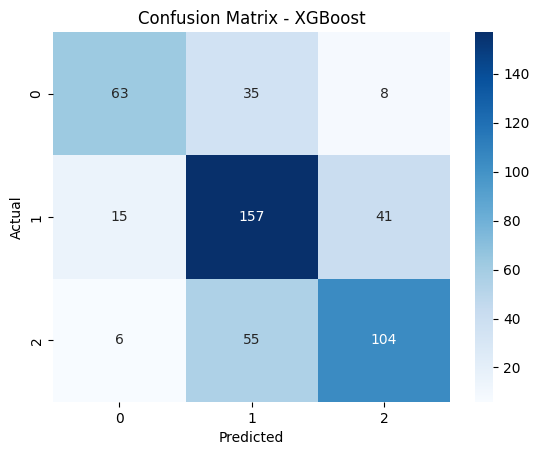

INFO:src.models.model_trainer:XGBoost Accuracy: 0.6694
INFO:src.models.model_trainer:Saved xgboost_classification model to models


Model Name: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)
XGBoost Accuracy: 0.6694
Report: {'0': {'precision': 0.75, 'recall': 0.5943396226415094, 'f1-score': 0.6631578947368421, 'support': 106.0}, '1': {'precision': 0.6356275303643725, 'recall': 0.7370892018779343, 'f1

In [5]:
# Cell: Initialize trainer and train
trainer = ModelTrainer(config)

# Convert object columns to categorical
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col] = data[col].astype('category')

# Prepare features and split data
X, y = trainer.prepare_features(data, target_variable='Label')
remove_cols = ['Future_Return']
X = X.drop(columns=remove_cols, errors='ignore')
X_train, X_test, y_train, y_test = trainer.split_data(X, y, test_size=0.2)

# Train XGBoost model
results = trainer.train_xgboost(X_train, y_train, X_test, y_test)

# Save models
trainer.save_models('models')

#Display results
print(f"Model Name:", results['model'])
print(f"XGBoost Accuracy: {results['accuracy']:.4f}")
#print(f"XGBoost F1 Score: {results['f1_score']:.4f}")
print(f"Report: {results['report']}")
#print(f"Confusion Matrix: {results['confusion_matrix']}")

In [5]:
# Save models
save_model = trainer.save_models('models_test_classification')

INFO:src.models.model_trainer:Saved xgboost_classification model to models_test_classification


In [6]:
save_model

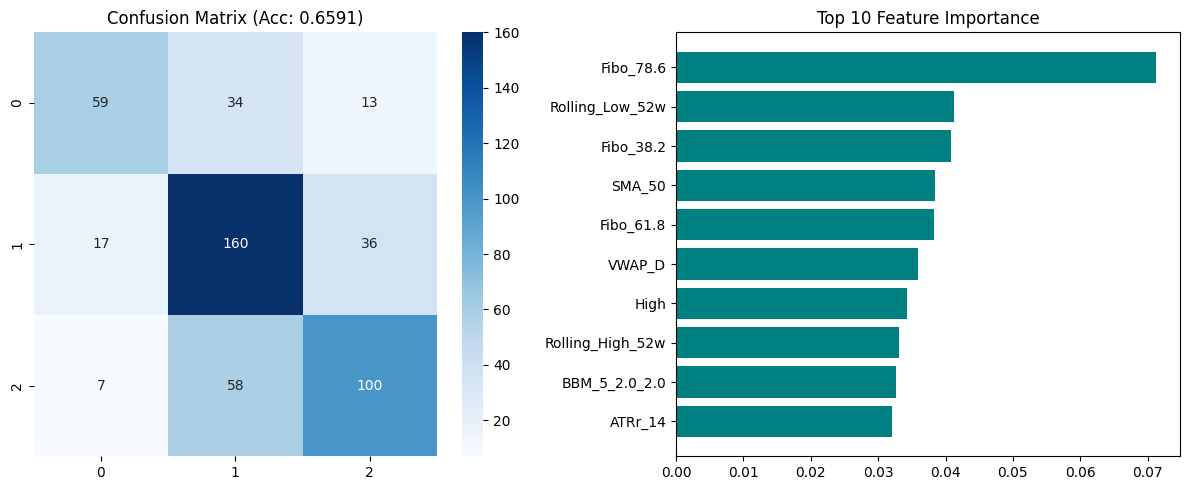

In [5]:
# call plot_model_performance
plot = trainer.plot_model_performance("xgboost_classification", X_test, y_test)


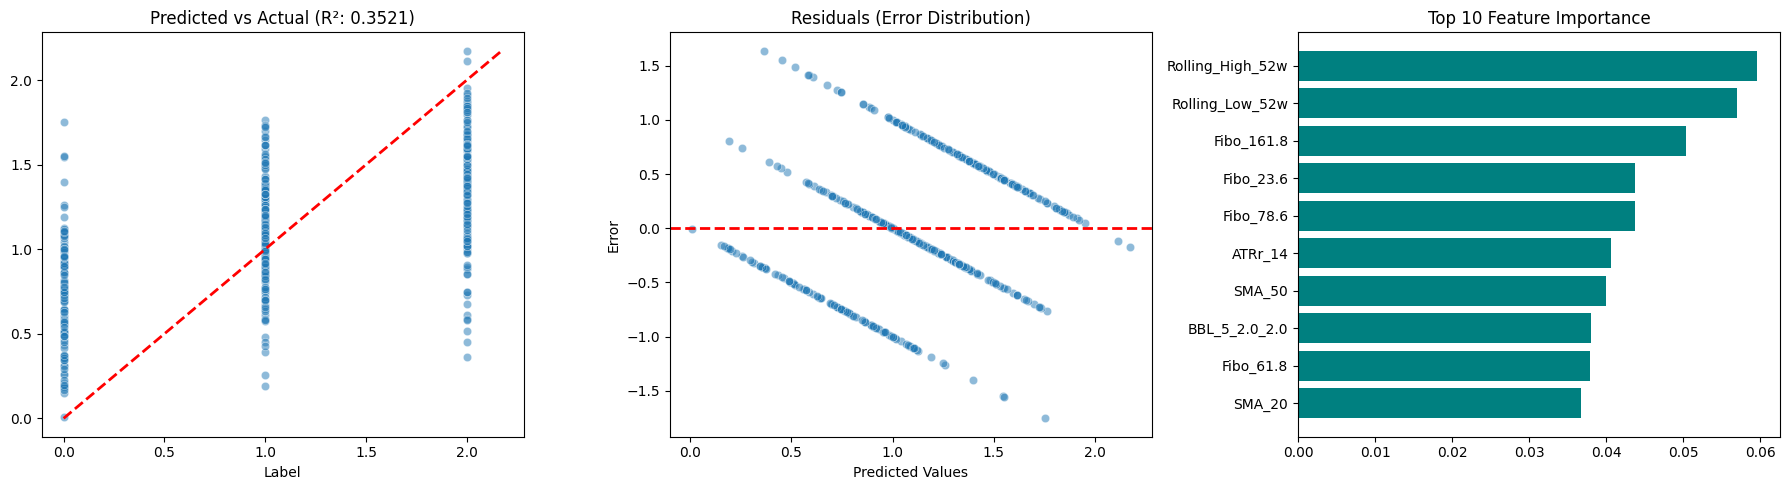

In [19]:
plot_regressor = trainer.plot_model_performance("xgboost", X_test, y_test)

In [4]:
# check score from models_test/xgboost_model.pkl
# Don't call Load_model, write new function for this purpose

import pickle
import logging as logger

def load_model(model_path: str):
    """Load a saved model from disk."""
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        logger.info(f"Model loaded from {model_path}")
        return model
    except Exception as e:
        logger.error(f"Error loading model from {model_path}: {e}")
        raise e

loaded_model = load_model(model_path=rf'D:\MSDS\buy-sell-hold-strategy-prediction\models_test_classification\xgboost_classification_model.pkl')
accuracy = loaded_model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")  

INFO:root:Model loaded from D:\MSDS\buy-sell-hold-strategy-prediction\models_test_classification\xgboost_classification_model.pkl


NameError: name 'X_test' is not defined

In [10]:
loaded_model.score(X_test, y_test)

0.6590909090909091

In [ ]:
# #confustion matrix of loaded model
# from sklearn.metrics import confusion_matrix
# y_pred_loaded = loaded_model.predict(X_test)
# cm_loaded = confusion_matrix(y_test, y_pred_loaded)
# print(cm_loaded)

[[ 60  36  10]
 [ 15 162  36]
 [  9  60  96]]


In [ ]:
# ## Call PortfolioBacktester to backtest the strategy from the model loaded_model
# backtester = PortfolioBacktester(config['strategy'])
# backtest_results = backtester.backtest_strategy(data=X_test, model=loaded_model)
# print(backtest_results)

AttributeError: 'PortfolioBacktester' object has no attribute 'backtest_strategy'

In [ ]:
backtester = PortfolioBacktester(config['strategy'])
# Get predictions for backtesting (using test set) FROM  trainer
predictions = results['predictions']
#Select the last N rows of data, where N is the length of predictions
test_data = data.iloc[-len(predictions):]



In [8]:
predictions

array([1, 2, 1, 1, 2, 0, 2, 1, 1, 2, 1, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1,
       1, 0, 1, 0, 2, 0, 2, 1, 2, 1, 2, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 2, 1, 2, 2,
       1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2,
       1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2,
       1, 2, 1, 0, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1,
       2, 1, 2, 1, 0, 1, 0, 0, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1,
       1, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 0, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2,
       0, 1, 1, 2, 1, 0, 2, 2, 2, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1,
       2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 0, 2,
       2, 0, 1, 0, 0, 2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 0,
       1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 1, 1, 2, 2, 1, 1,
       1, 0, 2, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2,

In [ ]:
test_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,SMA_50,RSI_14,...,Rolling_Low_52w,Fibo_23.6,Fibo_38.2,Fibo_50.0,Fibo_61.8,Fibo_78.6,Fibo_100.0,Fibo_161.8,Future_Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-17 00:00:00-05:00,188.470087,188.598876,186.805812,187.915329,50922700,0.0,0.0,176.883463,175.054464,71.178725,...,122.324586,178.499976,167.764888,159.088585,150.412281,138.059578,122.324586,76.884285,0.000527,1
2023-11-20 00:00:00-05:00,188.113456,190.114562,188.103555,189.658859,46505100,0.0,0.0,177.808605,175.298677,73.312571,...,122.324586,178.499976,167.764888,159.088585,150.412281,138.059578,122.324586,76.884285,-0.005484,1
2023-11-21 00:00:00-05:00,189.619230,189.728202,187.964856,188.856430,38134500,0.0,0.0,178.671861,175.587389,70.717561,...,122.324586,178.499976,167.764888,159.088585,150.412281,138.059578,122.324586,76.884285,-0.006662,1
2023-11-22 00:00:00-05:00,189.698511,191.125027,189.044682,189.520187,39617700,0.0,0.0,179.684058,175.930731,71.612663,...,122.324586,178.499976,167.764888,159.088585,150.412281,138.059578,122.324586,76.884285,-0.007109,1
2023-11-24 00:00:00-05:00,189.084308,189.114026,187.479469,188.192734,24048300,0.0,0.0,180.838138,176.217249,67.189227,...,122.324586,178.499976,167.764888,159.088585,150.412281,138.059578,122.324586,76.884285,0.006685,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-17 00:00:00-04:00,247.779801,253.134610,247.030527,252.045654,49147000,0.0,0.0,253.247501,240.831737,56.517429,...,168.633375,237.665020,224.473109,213.811153,203.149198,187.969464,168.633375,112.793642,0.041738,2
2025-10-20 00:00:00-04:00,255.642182,264.123965,255.382439,261.986023,90483000,0.0,0.0,253.555203,241.494095,66.331993,...,168.633375,241.588186,227.646560,216.378670,205.110781,189.068362,168.633375,109.620191,0.025053,2
2025-10-21 00:00:00-04:00,261.626381,265.033082,261.576411,262.515503,46695900,0.0,0.0,253.971799,242.205206,66.762340,...,168.633375,242.282751,228.208394,216.833229,205.458063,189.262913,168.633375,109.058357,0.023709,2


: 

In [7]:
# Create signals
signals = backtester.create_signals_from_predictions(
    test_data,
    predictions,
    config['strategy']['buy_threshold'],
    config['strategy']['sell_threshold']
)

# Run backtest
portfolio = backtester.run_backtest(
    test_data['Close'],
    signals['entries'],
    signals['exits'],
    config['strategy']['initial_capital'],
    config['strategy']['commission']
)

# Get performance metrics
metrics = backtester.get_performance_metrics()

# Compare with buy and hold
comparison = backtester.compare_with_buy_and_hold(
    test_data['Close'],
    config['strategy']['initial_capital']
)

portfolio.plot().show()

INFO:src.models.backtester:Generated 153 entry signals
INFO:src.models.backtester:Generated 84 exit signals
INFO:src.models.backtester:Running backtest...
INFO:src.models.backtester:Backtest completed
INFO:src.models.backtester:Performance Metrics:
INFO:src.models.backtester:  total_return: -0.0883913901104212
INFO:src.models.backtester:  annual_return: -0.06741111975889369
INFO:src.models.backtester:  sharpe_ratio: -0.1756753047009009
INFO:src.models.backtester:  max_drawdown: -0.3564470405819583
INFO:src.models.backtester:  win_rate: 0.4915254237288136
INFO:src.models.backtester:  total_trades: 59
INFO:src.models.backtester:  final_value: 91160.86098895788
INFO:src.models.backtester:  profit_factor: 0.8838157522531895
INFO:src.models.backtester:Strategy Return: -8.84%
INFO:src.models.backtester:Buy & Hold Return: 38.00%
INFO:src.models.backtester:Outperformance: -46.84%
